In [9]:
!pip install deeplake


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 97.6 MB/s eta 0:00:00


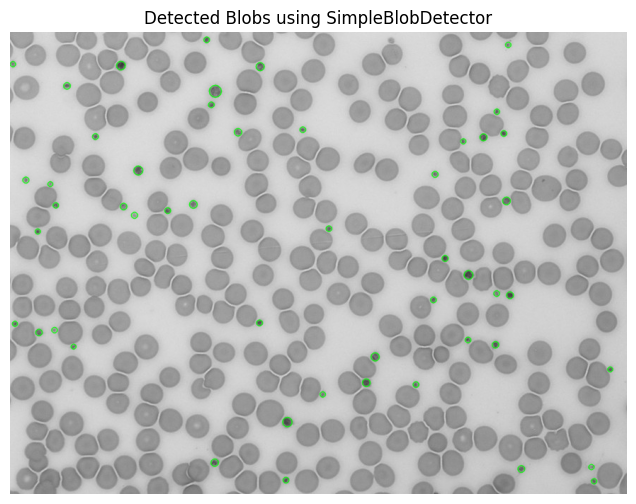

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = "blob.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


params = cv2.SimpleBlobDetector_Params()


params.filterByArea = True
params.minArea = 30
params.maxArea = 300


params.filterByCircularity = True
params.minCircularity = 0.2


params.filterByConvexity = True
params.minConvexity = 0.7


params.filterByInertia = True
params.minInertiaRatio = 0.2


detector = cv2.SimpleBlobDetector_create(params)


keypoints = detector.detect(image)


image_with_blobs = cv2.drawKeypoints(
    image, keypoints, np.array([]), (0, 255, 0),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)


plt.figure(figsize=(10, 6))
plt.imshow(image_with_blobs, cmap='gray')
plt.title("Detected Blobs using SimpleBlobDetector")
plt.axis("off")
plt.show()

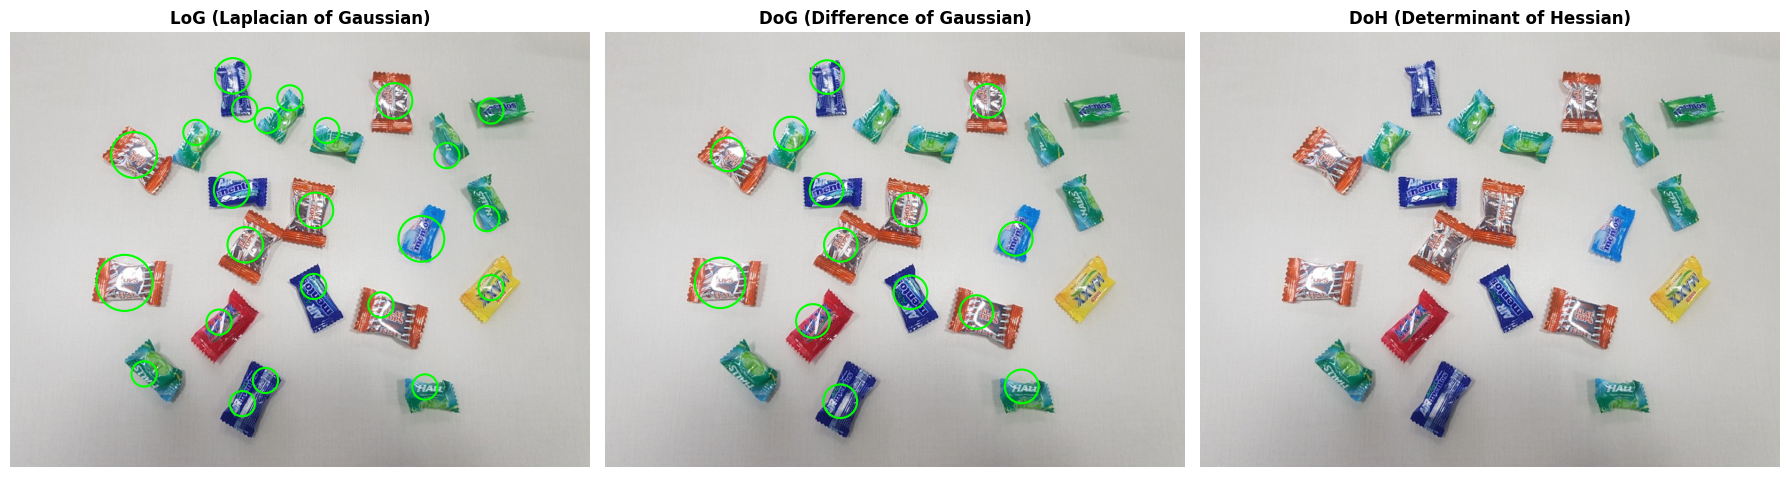

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_dog, blob_doh
from skimage import img_as_float
from skimage.filters import gaussian, sobel
from skimage.exposure import equalize_hist

# Load and preprocess the image (keeping it in color)
img_path = "blob4.jpg"
color_img = cv2.imread(img_path)

# Check if the image loaded successfully
if color_img is None:
    print("Error: Image not found or cannot be loaded.")
    exit()

# Convert the image to float and enhance contrast per channel
norm_img = img_as_float(color_img)
equalized_img = np.zeros_like(norm_img)
for channel in range(norm_img.shape[2]):
    equalized_img[:, :, channel] = equalize_hist(norm_img[:, :, channel])

# Edge enhancement using Sobel filter
edge_enhanced_img = np.zeros_like(equalized_img)
for channel in range(equalized_img.shape[2]):
    edge_enhanced_img[:, :, channel] = sobel(equalized_img[:, :, channel])

# Further noise reduction using Gaussian blur (with correct channel handling)
blurred_img = gaussian(edge_enhanced_img, sigma=1.5, channel_axis=-1)

# Apply LoG (Laplacian of Gaussian) with optimized parameters
detected_log = blob_log(
    blurred_img[:, :, 0], min_sigma=15, max_sigma=70, num_sigma=10,
    threshold=0.05, overlap=0.3
)
detected_log[:, 2] = detected_log[:, 2] * np.sqrt(2)

# Apply DoG (Difference of Gaussian) with optimized parameters
detected_dog = blob_dog(
    blurred_img[:, :, 0], min_sigma=20, max_sigma=80, sigma_ratio=1.5,
    threshold=0.05, overlap=0.3
)
detected_dog[:, 2] = detected_dog[:, 2] * np.sqrt(2)

# Convert the original image to grayscale and preprocess specifically for DoH
gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
preprocessed_doh = equalize_hist(img_as_float(gray_img))
preprocessed_doh = gaussian(preprocessed_doh, sigma=1.5)

# Apply DoH (Determinant of Hessian) with optimized parameters
detected_doh = blob_doh(
    preprocessed_doh, min_sigma=10, max_sigma=50, threshold=0.05
)


# Function to visualize blobs
def visualize_blobs(image, blob_sets, labels):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, blobs, lbl in zip(axes, blob_sets, labels):
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        for blob in blobs:
            y, x, r = blob
            circle = plt.Circle((x, y), r, color='lime', linewidth=1.5, fill=False)
            ax.add_patch(circle)
        ax.set_title(lbl, fontsize=12, fontweight='bold')
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Plot results
visualize_blobs(color_img, [detected_log, detected_dog, detected_doh],
                ["LoG (Laplacian of Gaussian)", "DoG (Difference of Gaussian)", "DoH (Determinant of Hessian)"])


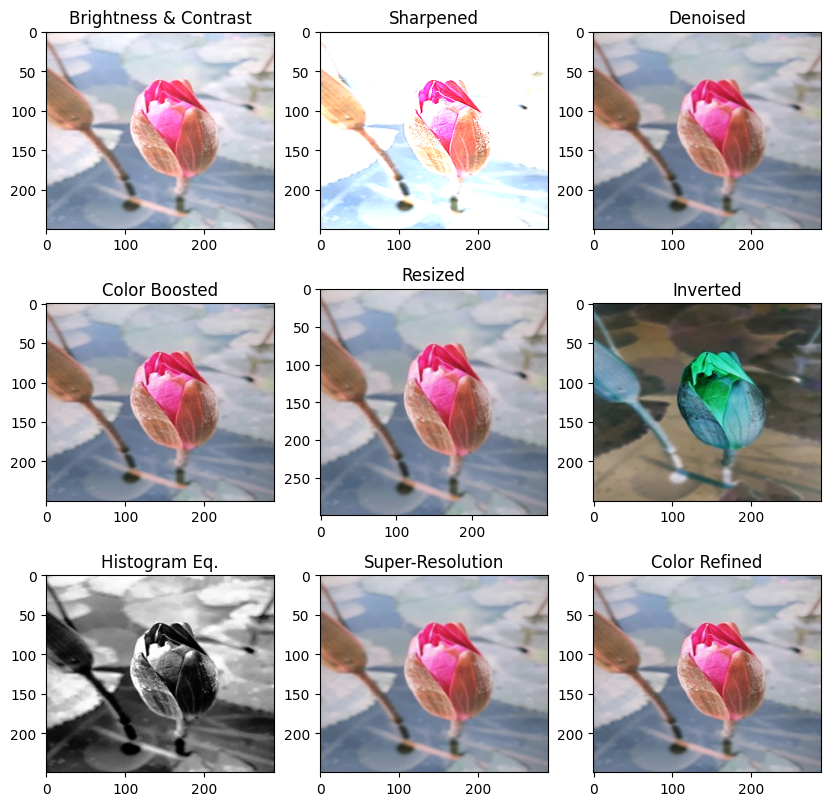

In [ ]:
import cv2
import numpy as np
from skimage.exposure import equalize_hist

img_source = "/content/22.jpg"
# Load Image
def read_image(img_source):
    with open(img_source, 'rb') as file:
        pic = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_COLOR)
    return cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)

# Image Enhancement Functions
def modify_brightness_contrast(pic, gain=1.1, offset=15):
    return cv2.convertScaleAbs(pic, alpha=gain, beta=offset)

def enhance_sharpness(pic):
    kernel_filter = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]])
    return cv2.filter2D(pic, -1, kernel_filter)

def smooth_image(pic):
    return cv2.GaussianBlur(pic, (3, 3), 0)

def boost_color(pic):
    hsv_image = cv2.cvtColor(pic, cv2.COLOR_RGB2HSV)
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def scale_image(pic, new_width, new_height):
    return cv2.resize(pic, (new_width, new_height))

def invert_colors(pic):
    return 255 - pic

def apply_hist_eq(pic):
    gray_image = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    return equalize_hist(gray_image)

def upscale_image(pic):
    enlarged = cv2.pyrUp(pic)
    return cv2.pyrDown(enlarged)

def refine_color(pic):
    hsv_data = cv2.cvtColor(pic, cv2.COLOR_RGB2HSV)
    lower_bound = np.array([0, 0, 0])
    upper_bound = np.array([255, 255, 255])
    mask_layer = cv2.inRange(hsv_data, lower_bound, upper_bound)
    return cv2.bitwise_and(pic, pic, mask=mask_layer)

# Example Usage
if __name__ == "__main__":
    path_to_img = "/content/22.jpg"  # Modify accordingly
    loaded_img = read_image(path_to_img)

    contrast_adjusted = modify_brightness_contrast(loaded_img)
    sharpened_img = enhance_sharpness(loaded_img)
    denoised_img = smooth_image(loaded_img)
    vivid_colors = boost_color(loaded_img)
    resized_img = scale_image(loaded_img, 300, 300)
    inverted_img = invert_colors(loaded_img)
    hist_equalized = apply_hist_eq(loaded_img)
    high_res = upscale_image(loaded_img)
    refined_colors = refine_color(loaded_img)

    # Display Results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 1), plt.imshow(contrast_adjusted), plt.title('Brightness & Contrast')
    plt.subplot(3, 3, 2), plt.imshow(sharpened_img), plt.title('Sharpened')
    plt.subplot(3, 3, 3), plt.imshow(denoised_img), plt.title('Denoised')
    plt.subplot(3, 3, 4), plt.imshow(vivid_colors), plt.title('Color Boosted')
    plt.subplot(3, 3, 5), plt.imshow(resized_img), plt.title('Resized')
    plt.subplot(3, 3, 6), plt.imshow(inverted_img, cmap='gray'), plt.title('Inverted')
    plt.subplot(3, 3, 7), plt.imshow(hist_equalized, cmap='gray'), plt.title('Histogram Eq.')
    plt.subplot(3, 3, 8), plt.imshow(high_res), plt.title('Super-Resolution')
    plt.subplot(3, 3, 9), plt.imshow(refined_colors), plt.title('Color Refined')
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time
from torchvision.models import vgg16, alexnet
from torch.utils.data import DataLoader

# Step 1: Set up the device for computation (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Step 3: Load Pretrained Models
def get_model(model_name):
    if model_name == "alexnet":
        model = alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(4096, 100)
    elif model_name == "vgg16":
        model = vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, 100)
    model = model.to(device)
    return model

# Training Function
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    end_time = time.time()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%, Inference Time: {end_time - start_time:.2f}s")
    return accuracy, end_time - start_time

# Train and Evaluate AlexNet
alexnet_model = get_model("alexnet")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=0.001)
train_model(alexnet_model, train_loader, criterion, optimizer, epochs=5)
alexnet_acc, alexnet_time = evaluate_model(alexnet_model, test_loader)

# Train and Evaluate VGG16
vgg16_model = get_model("vgg16")
optimizer = optim.Adam(vgg16_model.parameters(), lr=0.001)
train_model(vgg16_model, train_loader, criterion, optimizer, epochs=5)
vgg16_acc, vgg16_time = evaluate_model(vgg16_model, test_loader)

# Compare Results
print(f"AlexNet - Accuracy: {alexnet_acc:.2f}%, Time: {alexnet_time:.2f}s")
print(f"VGG16 - Accuracy: {vgg16_acc:.2f}%, Time: {vgg16_time:.2f}s")

100%|██████████| 169M/169M [00:08<00:00, 20.5MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weigh

KeyboardInterrupt: 